In [1]:
# Execute this first 
#
#  * trigger notebook styling
#  * check if notebook had been modified since its distribution
# 
# Note: executing any cells before this modifies the notebook.
# 
%run src/init_notebooks.py
hide_toggle()
check_notebook()

/Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/src/init_notebooks.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


ModuleNotFoundError: No module named 'notebook.notebookapp'

NameError: name 'check_notebook' is not defined

## A Beginner's Guide to Perform Molecular Dynamics Simulation of a Membrane Protein using GROMACS

**Authors  :** Farzaneh Jalalypour, Maryam Majdolhosseini, Alessandra Villa

**Goal     :** Learn step-by-step how to run a molecular dynamics simulation of a simple membrane protein using                   GROMACS\
**Reading time     :** 40 minutes\
**Software :** GROMACS 2023.2, python modules (numpy, matplotlib, nglviewer, MDTraj, and pandas)\
**Optional Software :** Visualization software [VMD](https://www.ks.uiuc.edu/Research/vmd), Xmgrace plotting tool\
**Tutorial Source   :** tutorials.gromacs.org\
**Version           :** Final 

**Small talk with the audience**

This tutorial is designed for beginner GROMACS users and assumes you understand the basics of MD simulations and are familiar with GROMACS files and how to generate and execute them. Don't worry if you are not yet acquainted. We have already developed an ["Introduction to Molecular Dynamics" tutorial](https://tutorials.gromacs.org/md-intro-tutorial.html) that covers all you need to know to get started with this one.

Please note that this tutorial is for educational purposes and and won't go through every step in details. For your system, you must change the settings accordingly (see [GROMACS documentation](http://manual.gromacs.org/current/index.html)). 

## Preparations to run this notebook

In [2]:
# Change to the data directory
# Note that executing this command twice will result in an error you can ignore
%cd data

/Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data


## Model system for this tutorial


For this tutorial, we will utilize maltoporin channel, a trimeric protein located at the outer membrane of Gram-negative bacteria that facilitates the translocation of the polysaccharide maltodextrin. You can download the 3D structure of maltoporin channel (PDB code 1MAL) from RCSB website [https://www.rcsb.org/structure/1MAL](https://www.rcsb.org/structure/1MAL) or use the previously downloded file, "1mal.pdb" in the "input" directory.

**Visualize the structure**

In [3]:
import nglview as ng
view = ng.show_structure_file("input/1mal.pdb")
view
#click and drag to rotate, zoom with your mouseweel 
#for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

## System preparation for this tutorial

**Building the protein-membrane system in CHARMM-GUI**

We are now ready to embed the protein structure in the membrane in the proper location and orientation and construct the membrane composition we desire. To do this, we utilized the CHARMM-GUI input Generator, a handy web-based tool to generate GROMACS inputs for the protein-membrane system. In order to access CHARMM-GUI (http://www.charmm-gui.org), a web browser such as Chrome, Firefox, etc. is required. 

In this Tutorial, rather than providing an in-depth discussion of how to create input via CHARMM-GUI, we will focus on how to perform a correct simulation using GROMACS. However, you can find useful information on [Membrane Builder Intro](https://charmm-gui.org/?doc=tutorial&project=membrane&chapter=membrane_intro) and in this [Membrane Proteins
Tutorial](https://www.ks.uiuc.edu/Training/Tutorials/science/membrane2/memprot2-tutorial.pdf) .


CHARMM-GUI generates all required input files as a zip file. You can unzip the file using the command below, or directly use the previously unzipped folder named "charmm-gui-1MAL". This folder contains a diverse set of files.

In [4]:
## command to unzip the zip file. The command is executable when you remove the hashtags
#import shutil
#shutil.unpack_archive('input/charmm-gui-1MAL.zip')
#print("Archive file unpacked successfully.")
#ls input

What we require, though, is in a "gromacs" folder. Let's take a closer look:

In [5]:
%ls input/charmm-gui-1MAL/gromacs/

README                     step6.3_equilibration.mdp
index.ndx                  step6.4_equilibration.mdp
step5_input.gro            step6.5_equilibration.mdp
step5_input.pdb            step6.6_equilibration.mdp
step5_input.psf            step7_production.mdp
step6.0_minimization.mdp   topol.top
step6.1_equilibration.mdp  toppar/
step6.2_equilibration.mdp


In a prior tutorial titled ["Introduction to Molecular Dynamics"](https://tutorials.gromacs.org/docs/md-intro-tutorial.html), you may get an explanation for each file including structure and topology files. 
Some of these mdp files may need to be changed to fit the system as further discussed in the next section.

Now lets create a new folder, called "run". Here we will perform the minimization and equilibration steps. Ensure that you are always in the correct working directory, you can use the `pwd` command, which stands for "print working directory". The command can be used to determine what directory you are currently working in.

In [6]:
# Creat working directory named run
%mkdir run
# Change to the directory "run"
%cd run

/Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data/run


In [7]:
# Make sure you are in the right folder. This will show you the path :) 
!pwd

/Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data/run


# Modified MDP files

Before starting the simulations we need the topology, parameter, and structure files. We will copy them from the `CHARMM-GUI-1MAL` folder to the `run` directory. Please note that mdp files are customized to fit the requirements of the system and they are located in the `input/mdp` folder. 

In [8]:
##copy required files to a folder
!scp    ../input/charmm-gui-1MAL/gromacs/step5_input.gro          .
!scp    ../input/charmm-gui-1MAL/gromacs/step5_input.pdb          .
!scp    ../input/charmm-gui-1MAL/gromacs/topol.top                .
!scp    ../input/charmm-gui-1MAL/gromacs/index.ndx                .
!scp -r ../input/charmm-gui-1MAL/gromacs/toppar                   .
#updated mdp files
!scp    ../input/mdp/*.mdp                                        . 

Because GROMACS always assumes a default value for each parameter, simulations may be conducted with an entirely empty mdp file. Hence, you must double-check each option to ensure that the default settings are acceptable. If not, you can modify the mdp file. GROMACS is user-friendly and prepared an intriguing list of possibilities that is clearly explained in [mdp options webpage](https://manual.gromacs.org/current/user-guide/mdp-options.html). To make your life easier, in all mdp files of this tutorial, a small explanation is included next to each parameter.

Now we have all required files to start minimization and equilibration parts:

In [9]:
%ls

index.ndx                            step6.4_equilibration_NPT_step2.mdp
step5_input.gro                      step6.5_equilibration_NPT_step3.mdp
step5_input.pdb                      step6.6_equilibration_NPT_step4.mdp
step6.0_minimization.mdp             step7_production_revised.mdp
step6.1_equilibration_NVT_step1.mdp  topol.top
step6.2_equilibration_NVT_step2.mdp  toppar/
step6.3_equilibration_NPT_step1.mdp


Lets start! Although it will take time, you can run the commands below one by one to generate files in every step. Fortunately, we have prepared output of runs ready to use if you prefer the quick route (see `input/reference` folder).

# Energy minimisation

Energy minimisation (EM) is used to relax the protein-membrane system by removing steric conflicts and improper geometry, e.g. to reduce excessive forces caused by too-close particle interaction in the system. We will first generate a binary (.tpr) file which assemble the structure(.gro), topology(.top), and simulation parameters(.mdp). Then we run energy minimization using `gmx mdrun`.

But first we go through the parameters in the minimization.mdp file:

In [10]:
#revised minimization.mdp
!cat ../input/mdp/step6.0_minimization.mdp

;;Preprocessing
title                   = CHARMM steepest descent energy minimization

; Position restraints   
;not applicable                      
;;Run and output control
integrator              = steep   ; A steepest descent algorithm for energy minimization
nsteps                  = 50000       ; Maximum number of steps to integrate or minimize
emtol                   = 1000.0      ; Tolerance [kJ mol-1 nm-1]
emstep                  = 0.01 

;;Neighbour searching
cutoff-scheme           = Verlet      ; Generate a pair list with buffering 
nstlist                 = 10          ; Frequency to update the neighbour list [steps]
rlist                   = 1.2


;;VdW
vdwtype                 = Cut-off
vdw-modifier            = Force-switch 
rvdw_switch             = 1.0         ; Where to start switching the LJ potential [nm]
rvdw                    = 1.2         ; Distance for the LJ or Buckingham cut-off [nm]

;;Electrostatics
coulombtype             = pme         ; Fast smooth Partic

In [18]:
## EM-step1  > to generate binary file
!gmx grompp -f step6.0_minimization.mdp -o minimization.tpr -c step5_input.gro  -r step5_input.gro -p topol.top

                 :-) GROMACS - gmx grompp, 2023.2-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023.2/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023.2
Working dir:  /Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data/run
Command line:
  gmx grompp -f step6.0_minimization.mdp -o minimization.tpr -c step5_input.gro -r step5_input.gro -p topol.top

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -1870402

Generated 1755 of the 1770 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 996 of the 1770 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'PROA'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PROB'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'PROC'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'POPC'

turning H bonds into constraints...

Excl

**Note:** From now on, if you want to run the commands on your system consider cells labelled with an odd number `##{number]##` and remove one hashtags from each line. But, if you want to use pre-prepared outputs remove hashtags of cells with even numbers.

In [12]:
##1## EM-step2 > to invoke mdrun
#!gmx mdrun -v -deffnm minimization

##The command is executable when you remove one of the hashtags

Five files (tpr,gro,trr,edr,log) are generated after you run the minimization command. You can always find the previously prepared files for each step in the reference folder:

In [19]:
##2## EM-step2 > To transfer minimization output from the reference directory to working directory

!scp ../reference/minimization* .

##remove one hashtag to transfer pre-prepared minimization files to working directory

In [20]:
#folder of pre-prepared outputs
%ls minimization*

minimization.edr  minimization.gro  minimization.log  minimization.tpr


Lets check if the minimization criteria are reached by looking at the last lines of the log file:

In [21]:
!tail -19 ../reference/minimization.log

           Bond            U-B    Proper Dih.  Improper Dih.      CMAP Dih.
    6.51312e+03    3.99821e+04    1.09620e+05    8.84017e+02   -4.51185e+03
          LJ-14     Coulomb-14        LJ (SR)   Coulomb (SR)   Coul. recip.
    2.19602e+04    1.27295e+05    8.22929e+04   -1.96235e+06    1.82224e+04
      Potential Pressure (bar)   Constr. rmsd
   -1.56009e+06    1.06214e+04    2.91337e-06


Steepest Descents converged to Fmax < 1000 in 2612 steps
Potential Energy  = -1.5600928e+06
Maximum force     =  9.6001355e+02 on atom 38587
Norm of force     =  1.1310057e+01

    D O M A I N   D E C O M P O S I T I O N   S T A T I S T I C S

 av. #atoms communicated per step for force:  2 x 128580.6

Finished mdrun on rank 0 Wed Sep 20 15:58:00 2023



There are two very important factors to evaluate to determine if energy minimization was successful. The first is the potential energy (printed at the end of the EM process, even without -v). The second important feature is the maximum force, Fmax, the target for which was set in minim.mdp - “emtol = 1000.0” - indicating a target Fmax of no greater than 1000 kJ/(mol nm). It is possible to arrive at a reasonable Epot with Fmax > emtol. If this happens, your system may not be stable enough for simulation. Evaluate why it may be happening, and perhaps change your minimization parameters (integrator, emstep, etc).

In [22]:
## Minimized structure
import nglview as ng
view = ng.show_structure_file("../reference/minimization.gro")
## Lipids
view.add_representation("ball+stick",selection="POPC")
## water
view.add_representation("licorice",selection="TIP3P", opacity=0.9)
view.center()
view
#Click and drag to rotate, zoom with your mouseweel 
#For more information on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

In alternative, remove the comment character (#) to use VMD:

In [23]:
#!vmd ../reference/minimization.gro

Let’s do a bit of analysis. The minimization.edr file contains all of the energy terms that GROMACS collects during EM. To extract energy information you can use the tool `gmx energy`  

In [24]:
!printf "Potential\n0\n" | gmx energy -f minimization.edr -o potential.xvg -xvg none

                 :-) GROMACS - gmx energy, 2023.2-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023.2/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023.2
Working dir:  /Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data/run
Command line:
  gmx energy -f minimization.edr -o potential.xvg -xvg none

Opened minimization.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir

<Axes: xlabel='step'>

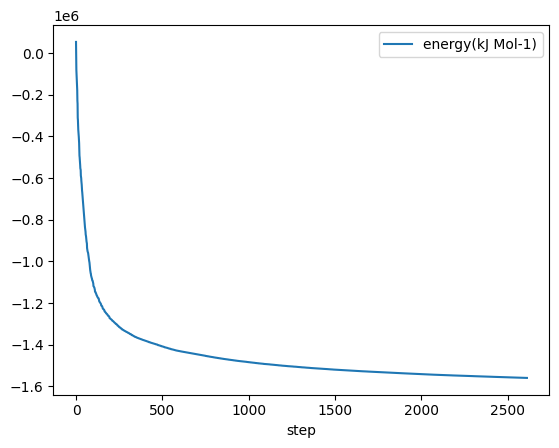

In [25]:
import pandas as pd
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy(kJ Mol-1)'])
df.plot('step')

Note: to analyse or visualize simulation data in python or jupyter notebooks, we can output a simplified xvg format from gmx-analysis tools with the option -xvg none

# Equilibration run - NVT

**position restraints**

For free proteins in solution, e.g. cytosolic proteins, position restraints are not as crucial as membrane proteins, where different parts of a system must be restrained in different levels and released gradually in several steps of minimization and equilibration. Otherwise you will end up in serious problems such as undesired change in system size and conformation.

To set position restraints we need to use the `define` option in the simulation parameter file, .mdp, which switch on by -DPOSRES flag. Have a look at the .mdp files for the following runs:

In [26]:
!head -4 ../input/mdp/step6.1_equilibration_NVT_step1.mdp 
!head -4 ../input/mdp/step6.2_equilibration_NVT_step2.mdp
!head -4 ../input/mdp/step6.3_equilibration_NPT_step1.mdp
!head -4 ../input/mdp/step6.4_equilibration_NPT_step2.mdp
!head -4 ../input/mdp/step6.5_equilibration_NPT_step3.mdp
!head -4 ../input/mdp/step6.6_equilibration_NPT_step4.mdp
!head -4 ../input/mdp/step7_production_revised.mdp

;;Preprocessing
; title                   = NVT equilibration 1

; Position restraints
;;Preprocessing
title                   = NVT equilibration 2
define                  = -DPOSRES -DPOSRES_FC_BB=2000.0 -DPOSRES_FC_SC=1000.0 -DPOSRES_FC_LIPID=400.0 -DDIHRES -DDIHRES_FC=400.0

;;Preprocessing
title                   = NPT equilibration 1
define                  = -DPOSRES -DPOSRES_FC_BB=1000.0 -DPOSRES_FC_SC=500.0 -DPOSRES_FC_LIPID=400.0 -DDIHRES -DDIHRES_FC=200.0

;;Preprocessing
title                   = NPT equilibration 2
define                  = -DPOSRES -DPOSRES_FC_BB=500.0 -DPOSRES_FC_SC=200.0 -DPOSRES_FC_LIPID=200.0 -DDIHRES -DDIHRES_FC=200.0

;;Preprocessing
title                   = NPT equilibration 3
define                  = -DPOSRES -DPOSRES_FC_BB=200.0 -DPOSRES_FC_SC=200.0 -DPOSRES_FC_LIPID=40.0 -DDIHRES -DDIHRES_FC=100.0

;;Preprocessing
title                   = NPT equilibration 4
define                  = -DPOSRES -DPOSRES_FC_BB=100.0 -DPOSRES_FC_SC=100.0 -DPOSRES

Let's use chain A (segment PROA) as an example to demonstrate how it works. The position restrain is defined in the last part of the itp file. `DPOSRES_FC_BB` and `POSRES_FC_SC` specify the type of restrains that apply to the different part of the protein. BB stands for the potein `BackBone` and SC for the protein `Side Chains`! Please execute the command below to see the position_restraints set for chain A:

In [27]:
!sed -n '59914,59932p'  ../input/charmm-gui-1MAL/gromacs/toppar/PROA.itp

#ifdef POSRES
[ position_restraints ]
; The backbone and side chains of the protein are restrained.
;   i    func     fcx             fcy               fcz
    1     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
    5     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
    7     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
    9     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   13     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   17     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
   18     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
   19     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
   21     1    POSRES_FC_BB    POSRES_FC_BB    POSRES_FC_BB   
   23     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   26     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   27     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   28     1    POSRES_FC_SC    POSRES_FC_SC    POSRES_FC_SC   
   29     1    POSRES_FC_

Hint: The number of atoms may be misleading. Please follow the PDB file to ensure which atoms are selected. Here you can find the atom numbers for the first two residues:

In [28]:
!head -n 30 ../input/charmm-gui-1MAL/gromacs/step5_input.pdb

ATOM      1  N   VAL     1      64.476  58.826  38.509  1.00  0.00      PROA N
ATOM      2  HT1 VAL     1      64.537  58.007  37.867  1.00  0.00      PROA H
ATOM      3  HT2 VAL     1      65.340  59.405  38.424  1.00  0.00      PROA H
ATOM      4  HT3 VAL     1      63.622  59.372  38.285  1.00  0.00      PROA H
ATOM      5  CA  VAL     1      64.370  58.316  39.907  1.00  0.00      PROA C
ATOM      6  HA  VAL     1      65.374  58.227  40.299  1.00  0.00      PROA H
ATOM      7  CB  VAL     1      63.544  59.304  40.762  1.00  0.00      PROA C
ATOM      8  HB  VAL     1      63.746  60.355  40.437  1.00  0.00      PROA H
ATOM      9  CG1 VAL     1      62.027  59.057  40.688  1.00  0.00      PROA C
ATOM     10 HG11 VAL     1      61.767  58.105  41.205  1.00  0.00      PROA H
ATOM     11 HG12 VAL     1      61.696  58.992  39.632  1.00  0.00      PROA H
ATOM     12 HG13 VAL     1      61.478  59.878  41.196  1.00  0.00      PROA H
ATOM     13  CG2 VAL     1      63.997  59.220  42.2

As you can see, the 1st and 5th atoms are N and CA protein backbone atoms of the first residue, respectively, and the value is defined by `POSRES_FC_BB` in PROA.itp file. The 7th and 9th are atom indexes of CB and CG which belong to the protein side chain and specify with `POSRES_FC_SC`. Take some moment to find the rest of the atoms and understand the concept by comparing itp and pdb files.

The P atoms of the lipid headgroups are constrained by `DPOSRES_FC_LIPID`. As the value is only determined for the Z direction, POPC lipid molecules can only move in the X-Y plane of the bilayer, maintaining the bilayer's thickness. `i` is the atom index of the P atom of the first POPC.

In [29]:
!sed -n '1271,1276p'  ../input/charmm-gui-1MAL/gromacs/toppar/POPC.itp

#ifdef POSRES
[ position_restraints ]
; Lipid P atoms are restrained in the xy plane:
;  i    func    fcx             fcy                 fcz
   20     1     0.0             0.0            POSRES_FC_LIPID
#endif


In POPC lipid molecules, two dihedral angles are typically restrained to preserve the cis-isomer. Here, the angles formed by C1-C3-C2-O21 and C28-C29-C210-C211 atoms are described by the atom indexes of the first POPC 25-36-28-30 and 60-63-65-67, respectively, and the value is defined by `DIHRES_FC`.

In [30]:
!sed -n '1278,1285p'  ../input/charmm-gui-1MAL/gromacs/toppar/POPC.itp

#ifdef DIHRES
[ dihedral_restraints ]
   25    36    28    30     1   -120.0      2.5       DIHRES_FC
   60    63    65    67     1      0.0      0.0       DIHRES_FC
#endif


# Equilibration run - NVT

To perform NVT equilibration we need two steps. In each step we will remove the restrains gradually to avoid undesired change in system size and conformation.

As discussed before, by removing the first hashtag (#) from the beginning of each line in odd-numbered cells, you may "uncomment" and execute them on your system, but be warned that it will take a while.
As an alternative, you can transfer the pre-prepared outputs by executing even-numbered cells to be able to countinue.

In [31]:
##1## equilibration-NVT6.1-step1 > To run
#!gmx grompp -f step6.1_equilibration_NVT_step1.mdp -o step6.1_equilibration_NVT_step1.tpr -c minimization.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.1_equilibration_NVT_step1

As an alternative, you can transfer the pre-prepared outputs by executing even-numbered cells to be able to countinue.

In [42]:
##2## equilibration-NVT6.1-step1 > To transfer
!scp    ../reference/step6.1_equilibration_NVT_step1*  .

Now we run step 2 using results from step 1 as input 

In [43]:
##3## equilibration-NVT6.2-step2 > To run
#!gmx grompp -f step6.2_equilibration_NVT_step2.mdp -o step6.2_equilibration_NVT_step2.tpr -c step6.1_equilibration_NVT_step1.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.2_equilibration_NVT_step2

As an alternative, you can transfer the pre-prepared outputs by executing even-numbered cells to be able to countinue.

In [49]:
##4## equilibration-NVT6.2-step2 > To transfer
!scp    ../reference/step6.2_equilibration_NVT_step2*  .

In [50]:
#Equilibration - NVT outputs
%ls ../reference/*NVT_step*

../reference/step6.1_equilibration_NVT_step1.edr
../reference/step6.1_equilibration_NVT_step1.gro
../reference/step6.1_equilibration_NVT_step1.tpr
../reference/step6.2_equilibration_NVT_step2.edr
../reference/step6.2_equilibration_NVT_step2.gro
../reference/step6.2_equilibration_NVT_step2.tpr


It is crucial to evaluate every step to ensure that the simulation is going right. For this purpose, we should check the tempurature using **gmx energy** tool. To plot the data, we used python data analysis library (pandas), but there are several alternatives out there such as Xmgrace tool.

**Evaluate temperature**

In [51]:
## check the temperature > To run
!echo 17|gmx energy -f step6.2_equilibration_NVT_step2.edr -o  NVT_S2-temp.xvg -xvg none

                 :-) GROMACS - gmx energy, 2023.2-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023.2/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023.2
Working dir:  /Users/tamay/Documents/Tutorial_membrane_protein_update/membrane-protein/data/run
Command line:
  gmx energy -f step6.2_equilibration_NVT_step2.edr -o NVT_S2-temp.xvg -xvg none

Opened step6.2_equilibration_NVT_step2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Dih.-Rest.    
 13  Potential       14  Kinetic-En.     15  Total-Energy    16  Con

<Axes: xlabel='time(ps)'>

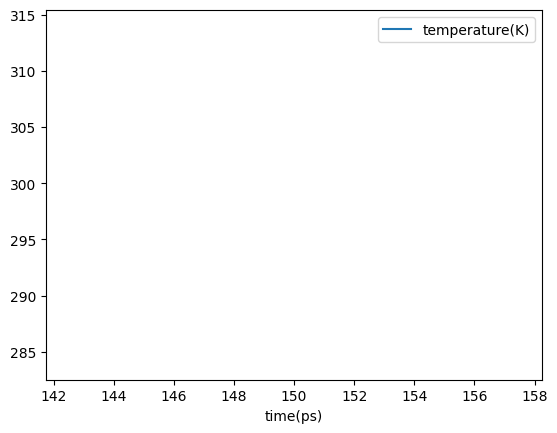

In [53]:
import pandas as pd
df = pd.read_csv('NVT_S2-temp.xvg', sep='\s+', header=None, names=['time(ps)','temperature(K)'])
df.plot('time(ps)')

In [48]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace ../run/NVT_S2-temp.xvg

**Evaluate the final structure**

It is also strongly recommended to visualise the final structure of each step:

In [ ]:
import nglview as ng
view = ng.show_structure_file("../reference/step6.1_equilibration_NVT_step1.gro")
## Lipids
view.add_representation("ball+stick",selection="POPC")
## water
view.add_representation("licorice",selection="TIP3P", opacity=0.9)
view.center()
view
#click and drag to rotate, zoom with your mouseweel 
#for more information on this viewer have a look at https://github.com/nglviewer/nglview

In [ ]:
import nglview as ng
view = ng.show_structure_file("../reference/step6.2_equilibration_NVT_step2.gro")
## Lipids
view.add_representation("ball+stick",selection="POPC")
## water
view.add_representation("licorice",selection="TIP3P", opacity=0.9)
view.center()
view

**Inside the mdp files**

As you may realize, the mdp files for EM and NVT are not the same. The `integrator` has been updated to md:

In [ ]:
!sed -n '8,8p'  ../input/mdp/step6.1_equilibration_NVT_step1.mdp
!sed -n '7,7p'  ../input/mdp/step6.0_minimization.mdp

And a temperature coupling section has been added: 

In [ ]:
!sed -n '42,55p' ../input/mdp/step6.1_equilibration_NVT_step1.mdp

In [ ]:
## For more details and compare at the entire files remove one hashtag
#!cat ../input/mdp/step6.0_minimization.mdp
#!cat ../input/mdp/step6.1_equilibration_NVT_step1.mdp

We used the v-rescale thermostat, which is the modified version of Berendsen having a stochastic term that assures the generation of a correct canonical ensemble. Sometimes you need to define groups, for instance to couple them separately. Here, SOLU_MEMB stands for protein and membrane, whereas SOLV stands for water and ions. If you're wondering about how we suggest these names, go through the index files. You can utilize pre-defined groups in the index file or even alter the index file to establish more groups if necessary. Typically, CHARMM-GUI provides five categories in the index file, as shown below:

|Group  |  Index | Molecules |
|--|--|--
|[ SOLU ]|1-19260|protein
|[ MEMB ]| 19261-39092|POPC
|[ SOLV ]| 39093-99055|ions and water
|[ SOLU_MEMB ]|1-39092|protein and POPC
|[ SYSTEM ]| 1-99055|whole

The interpretation of this information is as follows:

In [ ]:
!printf "q\n" | gmx make_ndx -f step5_input.gro -n index.ndx -o

You may also notice a variation in values if you look at the first lines of NVT mdp files. The sole difference between the prior stage (step6.1_equilibration_NVT_step1) and the final stage of NVT (step6.2_equilibration_NVT_step2) is that position restrains are gradually decreased and relaxed:

In [ ]:
!head -6 ../input/mdp/step6.1_equilibration_NVT_step1.mdp
!head -4 ../input/mdp/step6.2_equilibration_NVT_step2.mdp

# Equilibration run - NPT

Pressure equilibration takes place in an NPT ensemble. To keep the pressure stable, we turn the barostat on. We chose the semisotropic pressure coupling, which is isotropic in the x and y directions but not in the z, and is suitable for membrane simulations. Because Berendsen Barostat is outdated and Parrinello-Rahman is better to utilize 'only' in production runs when the structure is 'properly equilibrated', the c-rescale algorithm is appropriate for this part:

**Pressure coupling is on** 

pcoupl                  = c-rescale        

pcoupltype              = semiisotropic  

tau_p                   = 5.0        

compressibility         = 4.5e-5  4.5e-5 

ref_p                   = 1.0     1.0  

refcoord_scaling        = com

In order to minimize unintended changes in system size and conformation, NPT equilibration is carried out in four phases, with each step including a progressive removal of restraint.

In [ ]:
##9## equilibration-NPT6.3-step1 > To run
#!gmx grompp -f step6.3_equilibration_NPT_step1.mdp -o step6.3_equilibration_NPT_step1.tpr -c step6.2_equilibration_NVT_step2.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.3_equilibration_NPT_step1

In alternative:

In [ ]:
##10## equilibration-NPT6.3-step1 > To transfer
!scp    ../reference/step6.3_equilibration_NPT_step1*  .

In the next phases, we gradually reduce the constraints:

In [ ]:
##11## equilibration-NPT6.4-step2 > To run
#!gmx grompp -f step6.4_equilibration_NPT_step2.mdp -o step6.4_equilibration_NPT_step2.tpr -c step6.3_equilibration_NPT_step1.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.4_equilibration_NPT_step2

In alternative:

In [ ]:
##12## equilibration-NPT6.4-step2 > To transfer
!scp    ../reference/step6.4_equilibration_NPT_step2*  .

In [ ]:
##13## equilibration-NPT6.5-step3 > To run
#!gmx grompp -f step6.5_equilibration_NPT_step3.mdp -o step6.5_equilibration_NPT_step3.tpr -c step6.4_equilibration_NPT_step2.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.5_equilibration_NPT_step3

In alternative:

In [ ]:
##14## equilibration-NPT6.5-step3 > To transfer
!scp    ../reference/step6.5_equilibration_NPT_step3*  .

In [ ]:
##15## equilibration-NPT6.6-step4 > To run
#!gmx grompp -f step6.6_equilibration_NPT_step4.mdp -o step6.6_equilibration_NPT_step4.tpr -c step6.5_equilibration_NPT_step3.gro -r step5_input.gro -p topol.top -n index.ndx
#!gmx mdrun -v -deffnm step6.6_equilibration_NPT_step4

In alternative:

In [ ]:
##16## equilibration-NPT6.6-step4 > To transfer
!scp    ../reference/step6.6_equilibration_NPT_step4*  .

Here you can find the output of NPT steps:

In [ ]:
##Equilibration - NPT outputs
%ls ../reference/*NPT_step*

**Evaluate the Pressure**

`Attention`! I hope you have not forget to evaluate the temperature in each step so far. In NPT equilibration steps, we need to check at extra parameter, `pressure`:

In [ ]:
## check the pressure > To run
!echo 18|gmx energy -f step6.6_equilibration_NPT_step4.edr -o  NPT_S4_Press.xvg -xvg none

In [ ]:
import pandas as pd
import statistics
df = pd.read_csv('NPT_S4_Press.xvg', sep='\s+', header=None, names=['time(ps)','pressure(bar)'])
df.plot('time(ps)')

In [ ]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace NPT_S4_Press.xvg

As you can see, pressure fluctuate more than temprature which is totally ok :)

The system's temperature should rises to the desired level (~303 K) and stay steady for the rest of the equilibration. While, pressure is the parameter which fluctuates alot during the MD simulation, and its average should be statistically comparable with the pre-defined pressure (1 bar).

# Production
**Invoke mdrun for production (one single simulation)**

The system is now properly equilibrated and reached the appropriate temperature and pressure. The position restrictions may now be lifted, to start the production MD and begin data gathering.For production run, we will first generate the `binary tpr` filr using the following mdp parameters:

In [ ]:
!cat step7_production_revised.mdp

In [ ]:
##19.1## step7-production > To run
##generate tpr file
#!gmx grompp -f step7_production_revised.mdp -o step7_production.tpr -c step6.6_equilibration_NPT_step4.gro -t step6.6_equilibration_NPT_step4.cpt -p topol.top -n index.ndx

The completion of a production run (cell 19.2) might take hours or days. Dont execute this command here and try it on the terminal of the system you choose to perform the simulation.

**!Warning:** This run will generate roughly 9028 Mb of data

In [ ]:
##19.2## step7-production(one single simulation) > To run
#!gmx mdrun -s step7_production -cpi

A 100ns simulation was performed. Every 30000 of the 50000000 steps were recorded as the trajectory frames. The trr file is compressed into an xtc file. 
For convenience, we saved every 100 frames of the final trajectory and put the outputs in the reference folder.

In [ ]:
##20## step7-production > To transfer
!scp    ../reference/step7_production*  .

In [ ]:
##step7-production outputs
%ls *step7_production*

**Visualize the final structure**

In [ ]:
import nglview as ng
view = ng.show_structure_file("../reference/step7_production.gro")
## Lipids
view.add_representation("spacefill",selection="POPC", opacity=0.5)
## to see water box uncommand below:
#view.add_representation("spacefill",selection="TIP3P")
view.center()
view

**************************** 
**HINT**
**How to generate replicas?**
You may need more than one replica. You can generate several tpr file using random seed option for the velocity and temperature in the 'mdp' file. 

**How to run several replicas?**
You dont need to perform simulations separately, because GROMACS has a simple solution for that:
   
**step 1:** make folders (here we set four replicas) ***#mkdir Rep1 Rep2 Rep3 Rep4*** 
      
**step 2:** copy each tpr file in a different folder and execute mdrun by command below:
***#mpirun -np 4 gmx_mpi mdrun -v -s step7_production.tpr -multidir Rep1 Rep2 Rep3 Rep4 -cpi***

      
****************************
**Quiz**
Why we need to run several replicas? Do you know how they differ from one another? Exactly the same?

# Analysis

 **RMSD analysis**

In [ ]:
!echo 4 4 |gmx rms -s step7_production.tpr -f step7_production_traj_comp_skip100.xtc -o production_rmsd.xvg -bin production.rmsd.dat -tu ns -fit rot+trans -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('production_rmsd.xvg', sep='\s+', header=None, names=['time(ns)','RMSD(nm)'])
df.plot('time(ns)') 

The root mean square deviation (RMSD) is a practical parameter to compare the backbones of a protein from its initial to final state, which illustrates the dynamics of structure during the simulation. Here, the protein structure is pretty stable and fluctuates within expected margins(1-2 Å).

In [ ]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace production_rmsd.xvg

**Energy**

In [ ]:
##check the energy
!echo 13|gmx energy -f step7_production.edr -o production_Etot.xvg -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('production_Etot.xvg', sep='\s+', header=None, names=['time(ps)','Energy(kJ mol-1)'])
df.plot('time(ps)')

In [ ]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace production_Etot.xvg

**Tempurature**

In [ ]:
#check the tempurature
!echo 15|gmx energy -f step7_production.edr -o  production_temp.xvg -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('production_temp.xvg', sep='\s+', header=None, names=['time(ps)','Temperature*(K)'])
df.plot('time(ps)')

In [ ]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace production_temp.xvg

**Pressure**

In [ ]:
#check the pressure
!echo 16|gmx energy -f step7_production.edr -o production_press.xvg -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('production_press.xvg', sep='\s+', header=None, names=['time(ps)','Pressure(bar)'])
df.plot('time(ps)')

In [ ]:
##Alternative##Plotting data by Xmgrace tool
#!xmgrace production_press.xvg

**Trajectory Visualization**

In [ ]:
import nglview as ng
import mdtraj as md
trajectory = md.load("step7_production_traj_comp_skip100.xtc", top="step5_input.pdb")
view = ng.show_mdtraj(trajectory)
view.clear()
view.add_cartoon('protein',color_scheme='residueindex')
view

Now, place the mouse cursor over the protein press the play button. You will see the protein  wiggling and jiggling!

In [ ]:
view.clear()
view.add_cartoon('protein',color_scheme='residueindex')
view.add_spacefill('not TIP and not protein', opacity=0.6)
view.center()
view.camera = 'orthographic'
view

In this Part, lipids (gray and red spheres), and ions (green and purpule spheres) are illustrated. You can find the name of the atoms by simply placing the cursor on it. Try to find chloride ions.

Easy ha? Now try the tutorial on your protein and let us know if it is useful.
if you have any question write in the forum and we will answer as soon as possible: [http://forums.gromacs.org](http://forums.gromacs.org)

*References*
1. 